In [65]:
import cv2
import numpy as np
import os
import shutil
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from scipy import stats
from PIL import Image

In [66]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Color conversion from BGR to RGB
    image.flags.writeable = False                   # Image is no longer writeable
    results = model.process(image)                  # Make prediction
    image.flags.writeable = True                    # Image is no longer writeable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)   # Color conversion RGB to BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)  # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)    # Draw right connections

def draw_styled_landmarks(image,results):
    # Draw pose connection
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0,0,255), thickness=5,circle_radius=5),
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=5,circle_radius=5)
                              )
    # Draw left hand connection
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=5,circle_radius=5),
                              mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=5,circle_radius=5)
                              )
    # Draw right hand connection
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=5,circle_radius=5),
                              mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=5,circle_radius=5)
                              )
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,lh,rh])

Extracting Keypoints

In [67]:
# Specify the directory path
video_directory = r'test_interpolation'

# Get all file names in the directory
gestures_files = os.listdir(video_directory)

gesture_folder = np.array(gestures_files)
print(gesture_folder)

['ulang']


In [68]:
for gestures in gesture_folder:
    gesture = []

    for fname in os.listdir(os.path.join(video_directory, gestures)):
        path = os.path.join(video_directory, gestures, fname)
        if os.path.isdir(path):
            continue
        else:
            ges = os.path.splitext(fname)[0]
            gesture.append(ges)

    print(gestures, end =" : ")        
    print(gesture)

ulang : ['01', '02']


In [69]:
# Create landmark folder
for gestures in gesture_folder:
    gesture = []

    for fname in os.listdir(os.path.join(video_directory, gestures)):
        path = os.path.join(video_directory, gestures, fname)
        if os.path.isdir(path):
            continue
        else:
            ges = os.path.splitext(fname)[0]
            gesture.append(ges)
            
    for ges in gesture:
        file = os.path.splitext(ges)
        pre_path = os.path.join(video_directory, gestures, file[0])
        landmark_path = os.path.join(video_directory, gestures, file[0], 'landmarks')
        npy_path = os.path.join(landmark_path, )
                    
        if not os.path.exists(landmark_path):
            os.makedirs(landmark_path)
            print(landmark_path + " created")
        else:
            # if exist, delete folder and recreate the folder
            shutil.rmtree(pre_path, ignore_errors=True)
            os.makedirs(landmark_path)
            print("Exisiting " + landmark_path + " deleted and recreated")

Exisiting test_interpolation\ulang\01\landmarks deleted and recreated
Exisiting test_interpolation\ulang\02\landmarks deleted and recreated


In [70]:
# Create save location array
save_location_arr = []

for gestures in gesture_folder:
    gesture = []

    for fname in os.listdir(os.path.join(video_directory, gestures)):
        path = os.path.join(video_directory, gestures, fname)
        if os.path.isdir(path):
            continue
        else:
            ges = os.path.splitext(fname)[0]
            gesture.append(ges)
            
    for ges in gesture:
        file = os.path.splitext(ges)
        save_location_arr.append(os.path.join(video_directory, gestures, file[0]))

print(save_location_arr)

['test_interpolation\\ulang\\01', 'test_interpolation\\ulang\\02']


In [71]:
# Video Path array
video_path_arr = []

for gestures in gesture_folder:
    gesture = []

    for fname in os.listdir(os.path.join(video_directory, gestures)):
        path = os.path.join(video_directory, gestures, fname)
        if os.path.isdir(path):
            continue
        else:
            ges = os.path.splitext(fname)[0]
            gesture.append(ges)
            
    for ges in gesture:
        file = os.path.splitext(ges)
        video_path_arr.append(os.path.join(video_directory, gestures, file[0] + '.mp4'))

print(video_path_arr)

['test_interpolation\\ulang\\01.mp4', 'test_interpolation\\ulang\\02.mp4']


In [72]:
# iterate through the video path array and save the landmarks as images and npy files
for video_path, save_location in zip(video_path_arr, save_location_arr):
    video = cv2.VideoCapture(video_path)

    frame_count = 0

    while video.isOpened():
        ret, frame = video.read()

        if not ret:
            break

        frame_count += 1

        # Edit condifidence and model complexity
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5, model_complexity=2, smooth_landmarks=True) as holistic:
            frame, results = mediapipe_detection(frame, holistic)
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            draw_styled_landmarks(frame, results)

        # # create the dark image
        # black = np.zeros(frame.shape , np.uint8)

        # # Replace the `img` with `black` while drawing the landmarks
        # draw_styled_landmarks(black, results)

        # frame_save_path = f'{save_location}/{frame_count}.png'
        # cv2.imwrite(frame_save_path, black)

        # Save the landmarks as npy file
        npy_save_path = f'{save_location}/landmarks/{frame_count}.npy'
        np.save(npy_save_path, extract_keypoints(results))

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    video.release()
    cv2.destroyAllWindows()

    # If frame_count > 30, print video path
    if frame_count > 30:
        extra = frame_count - 30
        print(video_path + " exceeds by " + str(extra) + " frames")
    if frame_count < 30:
        extra = frame_count - 30
        print(video_path + " not enough " + str(extra) + " frames")

Initializing keypoints for interpolation

###### Before we can apply bilinear interpolation for missing keypoint reconstruction, we need to ensure every empty frame is now sandwiched between frames populated with keypoints. (Interpolation require at least one preceding and one succeeding frames with identified keypoints to serve as reference point)

In [73]:
import numpy as np

def initialize_hand_keypoints(frames_keypoints):
    """
    Initialize and the hand keypoints in a sequence of frames.

    Parameters:
    frames_keypoints (list of np.ndarray): List where each entry is a numpy array representing keypoints 
                                           for a frame, or None if keypoints are missing in that frame.
                                           
    Returns:
    list of np.ndarray: List with hand keypoints initialized and interpolated as needed.
    """
    # Define indices for left and right hand keypoints within the overall keypoint array
    pose_keypoints_count = 33 * 4
    left_hand_start = pose_keypoints_count
    left_hand_end = left_hand_start + 21 * 3
    right_hand_start = left_hand_end
    right_hand_end = right_hand_start + 21 * 3
    
    # Extract valid hand keypoints for averaging
    valid_left_hand_keypoints = [kp[left_hand_start:left_hand_end] for kp in frames_keypoints if kp is not None and (kp[left_hand_start] != 0.00000000e+00)]
    valid_right_hand_keypoints = [kp[right_hand_start:right_hand_end] for kp in frames_keypoints if kp is not None and (kp[right_hand_start] != 0.00000000e+00)]
    
    print("valid_left_hand", len(valid_left_hand_keypoints))
    print("valid_right_hand", len(valid_right_hand_keypoints))

    # Calculate average hand keypoints
    if valid_left_hand_keypoints:
        avg_left_hand = np.mean(valid_left_hand_keypoints, axis=0)
    else:
        avg_left_hand = np.zeros(21 * 3)
    
    if valid_right_hand_keypoints:
        avg_right_hand = np.mean(valid_right_hand_keypoints, axis=0)
    else:
        avg_right_hand = np.zeros(21 * 3)

    # Initialize the first and last frames if they have missing hand keypoints
    if frames_keypoints[0] is None or not np.any(frames_keypoints[0][left_hand_start:left_hand_end]):
        frames_keypoints[0][left_hand_start:left_hand_end] = avg_left_hand
    if frames_keypoints[0] is None or not np.any(frames_keypoints[0][right_hand_start:right_hand_end]):
        frames_keypoints[0][right_hand_start:right_hand_end] = avg_right_hand
    
    if frames_keypoints[-1] is None or not np.any(frames_keypoints[-1][left_hand_start:left_hand_end]):
        frames_keypoints[-1][left_hand_start:left_hand_end] = avg_left_hand
    if frames_keypoints[-1] is None or not np.any(frames_keypoints[-1][right_hand_start:right_hand_end]):
        frames_keypoints[-1][right_hand_start:right_hand_end] = avg_right_hand

    return frames_keypoints


In [74]:
import numpy as np

def find_neighbour_keypoints(frames_keypoints, k, frame, hand_start, hand_end):
    alpha_left = alpha_right = beta_left = beta_right = None

    # Search for α (previous frame with keypoints)
    for a in range(1, k + 1):
        if frames_keypoints[k - a] is not None and np.any(frames_keypoints[k - a][hand_start:hand_end]):
            alpha_left = a
            break

    # Search for β (next frame with keypoints)
    for b in range(1, len(frames_keypoints) - k):
        if frames_keypoints[k + b] is not None and np.any(frames_keypoints[k + b][hand_start:hand_end]):
            beta_left = b
            break

    # If α and β are found, interpolate
    if alpha_left is not None and beta_left is not None:
        f_k_alpha_left = frames_keypoints[k - alpha_left][hand_start:hand_end]
        f_k_beta_left = frames_keypoints[k + beta_left][hand_start:hand_end]
        frame[hand_start:hand_end] = (beta_left * f_k_alpha_left + alpha_left * f_k_beta_left) / (alpha_left + beta_left)

def bilinear_interpolation(frames_keypoints):
    """
    Apply bilinear interpolation to fill missing hand keypoints based on the provided formula.
    
    Parameters:
    frames_keypoints (list of np.ndarray): List where each entry is a numpy array representing keypoints 
                                           for a frame, or None if keypoints are missing in that frame.
                                           
    Returns:
    list of np.ndarray: List of frames with interpolated hand keypoints.
    """
    # Define indices for left and right hand keypoints within the overall keypoint array
    pose_keypoints_count = 33 * 4
    left_hand_start = pose_keypoints_count
    left_hand_end = left_hand_start + 21 * 3
    right_hand_start = left_hand_end
    right_hand_end = right_hand_start + 21 * 3

    # Process each frame
    for k in range(len(frames_keypoints)):
        frame = frames_keypoints[k]
        
        # Check if current frame's hand keypoints are missing
        if frame is None or (frame[left_hand_start] == 0.00000000e+00 or frame[right_hand_start] == 0.00000000e+00):
            # Find α and β for left and right hands
            # Initialize α and β to None as we search

            if frame[left_hand_start] == 0.00000000e+00:
                find_neighbour_keypoints(frames_keypoints, k, frame, left_hand_start, left_hand_end)
                print('frame ', k + 1, ' left hand keypoints interpolated')

            if frame[right_hand_start] == 0.00000000e+00:
                find_neighbour_keypoints(frames_keypoints, k, frame, right_hand_start, right_hand_end)
                print('frame ', k + 1, ' right hand keypoints interpolated')

            # alpha_left = alpha_right = beta_left = beta_right = None
            
            # # Search for α (previous frame with keypoints)
            # for a in range(1, k + 1):
            #     if frames_keypoints[k - a] is not None and np.any(frames_keypoints[k - a][left_hand_start:left_hand_end]):
            #         alpha_left = a
            #         break
            # for a in range(1, k + 1):
            #     if frames_keypoints[k - a] is not None and np.any(frames_keypoints[k - a][right_hand_start:right_hand_end]):
            #         alpha_right = a
            #         break
            
            # # Search for β (next frame with keypoints)
            # for b in range(1, len(frames_keypoints) - k):
            #     if frames_keypoints[k + b] is not None and np.any(frames_keypoints[k + b][left_hand_start:left_hand_end]):
            #         beta_left = b
            #         break
            # for b in range(1, len(frames_keypoints) - k):
            #     if frames_keypoints[k + b] is not None and np.any(frames_keypoints[k + b][right_hand_start:right_hand_end]):
            #         beta_right = b
            #         break
            
            # # If α and β are found, interpolate
            # if alpha_left is not None and beta_left is not None:
            #     f_k_alpha_left = frames_keypoints[k - alpha_left][left_hand_start:left_hand_end]
            #     f_k_beta_left = frames_keypoints[k + beta_left][left_hand_start:left_hand_end]
            #     frame[left_hand_start:left_hand_end] = (beta_left * f_k_alpha_left + alpha_left * f_k_beta_left) / (alpha_left + beta_left)
            
            # if alpha_right is not None and beta_right is not None:
            #     f_k_alpha_right = frames_keypoints[k - alpha_right][right_hand_start:right_hand_end]
            #     f_k_beta_right = frames_keypoints[k + beta_right][right_hand_start:right_hand_end]
            #     frame[right_hand_start:right_hand_end] = (beta_right * f_k_alpha_right + alpha_right * f_k_beta_right) / (alpha_right + beta_right)
    
    return frames_keypoints


In [75]:
def load_keypoints(folder_path):
    """
    Load the keypoints from a given file path.
    
    Parameters:
    path (str): Path to the .npy file containing the keypoints.
    
    Returns:
    list of np.ndarray: List of frames where each frame is a numpy array representing keypoints.
    """
    frames_keypoints = []

    files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    print(files)

    # arrange files in ascending order
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    print(files)

    # Load the keypoints from the .npy file
    for file in files:
        file_path = os.path.join(folder_path, file)
        frame_keypoints = np.load(file_path)
        frames_keypoints.append(frame_keypoints)

    return frames_keypoints

In [76]:
test = load_keypoints('test_interpolation/ulang/02/landmarks')
test = initialize_hand_keypoints(test)

['1.npy', '10.npy', '11.npy', '12.npy', '13.npy', '14.npy', '15.npy', '16.npy', '17.npy', '18.npy', '19.npy', '2.npy', '20.npy', '21.npy', '22.npy', '23.npy', '24.npy', '25.npy', '26.npy', '27.npy', '28.npy', '29.npy', '3.npy', '30.npy', '4.npy', '5.npy', '6.npy', '7.npy', '8.npy', '9.npy']
['1.npy', '2.npy', '3.npy', '4.npy', '5.npy', '6.npy', '7.npy', '8.npy', '9.npy', '10.npy', '11.npy', '12.npy', '13.npy', '14.npy', '15.npy', '16.npy', '17.npy', '18.npy', '19.npy', '20.npy', '21.npy', '22.npy', '23.npy', '24.npy', '25.npy', '26.npy', '27.npy', '28.npy', '29.npy', '30.npy']
valid_left_hand 7
valid_right_hand 30


In [77]:
test = bilinear_interpolation(test)

frame  2  left hand keypoints interpolated
frame  3  left hand keypoints interpolated
frame  4  left hand keypoints interpolated
frame  7  left hand keypoints interpolated
frame  8  left hand keypoints interpolated
frame  9  left hand keypoints interpolated
frame  10  left hand keypoints interpolated
frame  11  left hand keypoints interpolated
frame  12  left hand keypoints interpolated
frame  13  left hand keypoints interpolated
frame  14  left hand keypoints interpolated
frame  17  left hand keypoints interpolated
frame  18  left hand keypoints interpolated
frame  19  left hand keypoints interpolated
frame  20  left hand keypoints interpolated
frame  21  left hand keypoints interpolated
frame  22  left hand keypoints interpolated
frame  23  left hand keypoints interpolated
frame  24  left hand keypoints interpolated
frame  27  left hand keypoints interpolated
frame  28  left hand keypoints interpolated


In [78]:
def save_keypoints(frames_keypoints, folder_path):
    """
    Save the keypoints to a given file path.
    
    Parameters:
    frames_keypoints (list of np.ndarray): List of frames where each frame is a numpy array representing keypoints.
    folder_path (str): Path to the folder where the keypoints will be saved.
    """
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    else:
        # if exist, delete folder and recreate the folder
        shutil.rmtree(folder_path, ignore_errors=True)
        os.makedirs(folder_path)

    for i, frame_keypoints in enumerate(frames_keypoints):
        file_path = os.path.join(folder_path, f'{i + 1}.npy')
        np.save(file_path, frame_keypoints)

In [79]:
save_keypoints(test, 'test_interpolation/ulang/02/interpolated')

Verifying NPY file is correct

In [80]:
def plot_keypoints(keypoints, title):
    # Separate pose, left hand, and right hand keypoints based on sizes
    pose = keypoints[:33 * 4].reshape(-1, 4)        # 33 keypoints, each with [x, y, z, visibility]
    left_hand = keypoints[33 * 4:33 * 4 + 21 * 3].reshape(-1, 3)  # 21 keypoints for left hand, each with [x, y, z]
    right_hand = keypoints[33 * 4 + 21 * 3:].reshape(-1, 3)       # 21 keypoints for right hand, each with [x, y, z]

    # Define connections (edges) between keypoints for pose, left hand, and right hand
    # These connections are based on a standard pose model, such as MediaPipe's Pose model.
    pose_connections = [
        (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8), (9, 10),
        (11, 12), (11, 13), (13, 15), (15, 17), (15, 19), (15, 21), (17, 19),
        (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), (18, 20), (23, 24),
        (23, 25), (24, 26), (25, 27), (26, 28), (27, 29), (28, 30), (29, 31), (30, 32)
    ]

    hand_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4), # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8), # Index finger
        (0, 9), (9, 10), (10, 11), (11, 12), # Middle finger
        (0, 13), (13, 14), (14, 15), (15, 16), # Ring finger
        (0, 17), (17, 18), (18, 19), (19, 20) # Pinky
    ]

    # Plot keypoints with connections
    plt.figure(figsize=(16, 9))
    plt.axis([0, 1.125, 0, 2])

    # Plot pose keypoints and connections
    for (start, end) in pose_connections:
        plt.plot([pose[start, 0], pose[end, 0]], [pose[start, 1], pose[end, 1]], 'k-', lw=2)
    plt.scatter(pose[:, 0], pose[:, 1], label='Pose', s=20, alpha=0.7)

    # Plot left hand keypoints and connections
    for (start, end) in hand_connections:
        plt.plot([left_hand[start, 0], left_hand[end, 0]], [left_hand[start, 1], left_hand[end, 1]], 'b-', lw=2)
    plt.scatter(left_hand[:, 0], left_hand[:, 1], label='Left Hand', s=20, alpha=0.7)

    # Plot right hand keypoints and connections
    for (start, end) in hand_connections:
        plt.plot([right_hand[start, 0], right_hand[end, 0]], [right_hand[start, 1], right_hand[end, 1]], 'r-', lw=2)
    plt.scatter(right_hand[:, 0], right_hand[:, 1], label='Right Hand', s=20, alpha=0.7)

    # Adjust plot settings
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.title(title)
    plt.legend()
    plt.gca().invert_yaxis()  # Invert Y axis for typical image coordinates
    plt.show()

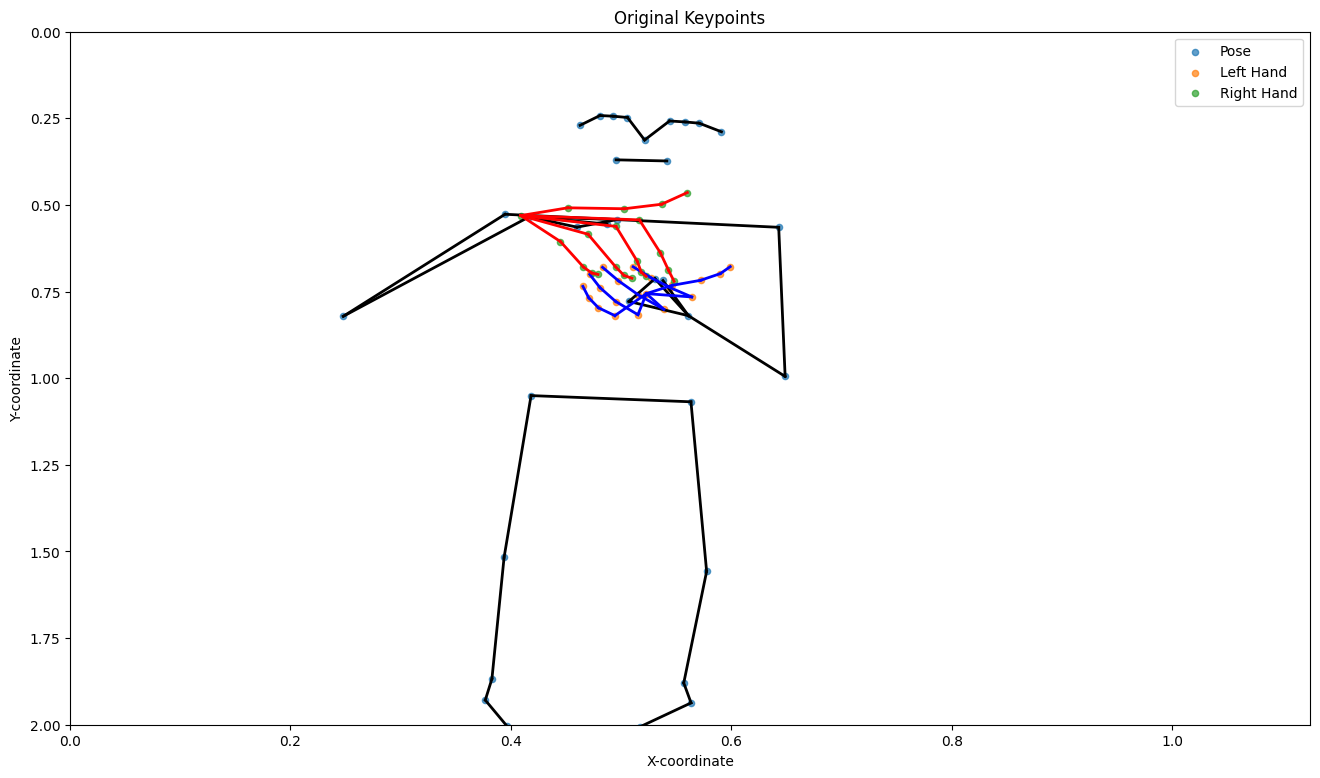

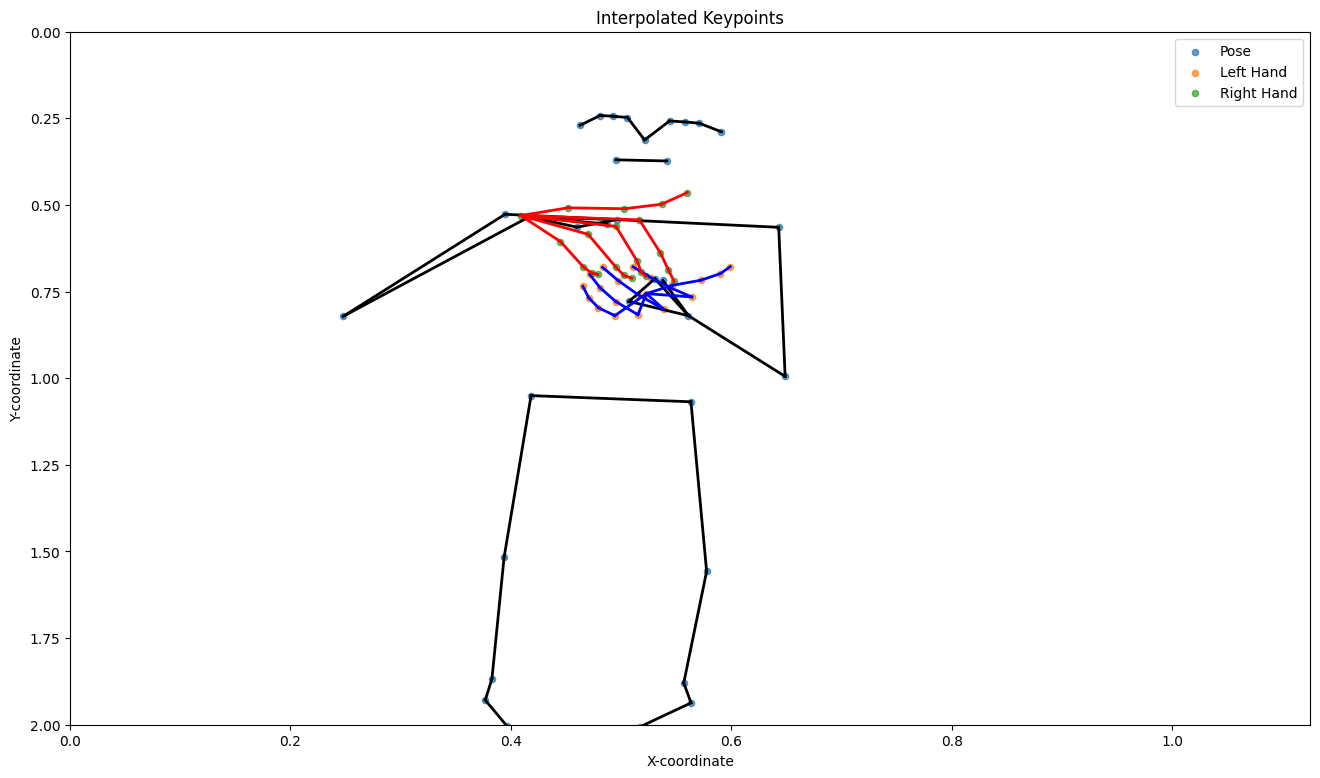

In [81]:
npy_file = '5.npy'
npy_file2 = '5.npy'
keypoints = np.load(os.path.join('test_interpolation/ulang/02/landmarks', npy_file))
keypoints_interpolated = np.load(os.path.join('test_interpolation/ulang/02/interpolated', npy_file2))

plot_keypoints(keypoints, title='Original Keypoints')
plot_keypoints(keypoints_interpolated, title='Interpolated Keypoints')

In [82]:
np.load(os.path.join('test_interpolation/ulang/02/landmarks', npy_file))

array([ 5.21284521e-01,  3.12488616e-01, -6.20897889e-01,  9.99986410e-01,
        5.43911278e-01,  2.57565916e-01, -5.90697169e-01,  9.99956489e-01,
        5.58152795e-01,  2.60427296e-01, -5.91033995e-01,  9.99963284e-01,
        5.70810914e-01,  2.63964355e-01, -5.91148376e-01,  9.99951720e-01,
        5.05754173e-01,  2.47557744e-01, -5.82104802e-01,  9.99974489e-01,
        4.92941529e-01,  2.43861616e-01, -5.82743764e-01,  9.99984741e-01,
        4.80807126e-01,  2.41826117e-01, -5.83152115e-01,  9.99979615e-01,
        5.91038644e-01,  2.88827121e-01, -3.74124438e-01,  9.99982715e-01,
        4.62748021e-01,  2.70100057e-01, -3.35046947e-01,  9.99979734e-01,
        5.41471720e-01,  3.72997224e-01, -5.32650054e-01,  9.99943614e-01,
        4.95409548e-01,  3.69704485e-01, -5.24007022e-01,  9.99954104e-01,
        6.42953932e-01,  5.64456403e-01, -2.13128045e-01,  9.99966025e-01,
        3.94686133e-01,  5.26834130e-01, -1.55317351e-01,  9.99975324e-01,
        6.48785830e-01,  

In [83]:
np.load(os.path.join('test_interpolation/ulang/02/interpolated', npy_file2))

array([ 5.21284521e-01,  3.12488616e-01, -6.20897889e-01,  9.99986410e-01,
        5.43911278e-01,  2.57565916e-01, -5.90697169e-01,  9.99956489e-01,
        5.58152795e-01,  2.60427296e-01, -5.91033995e-01,  9.99963284e-01,
        5.70810914e-01,  2.63964355e-01, -5.91148376e-01,  9.99951720e-01,
        5.05754173e-01,  2.47557744e-01, -5.82104802e-01,  9.99974489e-01,
        4.92941529e-01,  2.43861616e-01, -5.82743764e-01,  9.99984741e-01,
        4.80807126e-01,  2.41826117e-01, -5.83152115e-01,  9.99979615e-01,
        5.91038644e-01,  2.88827121e-01, -3.74124438e-01,  9.99982715e-01,
        4.62748021e-01,  2.70100057e-01, -3.35046947e-01,  9.99979734e-01,
        5.41471720e-01,  3.72997224e-01, -5.32650054e-01,  9.99943614e-01,
        4.95409548e-01,  3.69704485e-01, -5.24007022e-01,  9.99954104e-01,
        6.42953932e-01,  5.64456403e-01, -2.13128045e-01,  9.99966025e-01,
        3.94686133e-01,  5.26834130e-01, -1.55317351e-01,  9.99975324e-01,
        6.48785830e-01,  

In [84]:
# npy file to gif
def create_gif(folder_path, gif_path):
    """
    Create a GIF from the images in a folder.
    
    Parameters:
    folder_path (str): Path to the folder containing the npy files.
    gif_path (str): Path where the GIF will be saved.
    """
    files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    images = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        keypoints = np.load(file_path)
        image = plot_keypoints(keypoints, title='Keypoints')
        images.append(image)

    imageio.mimsave(gif_path, images)



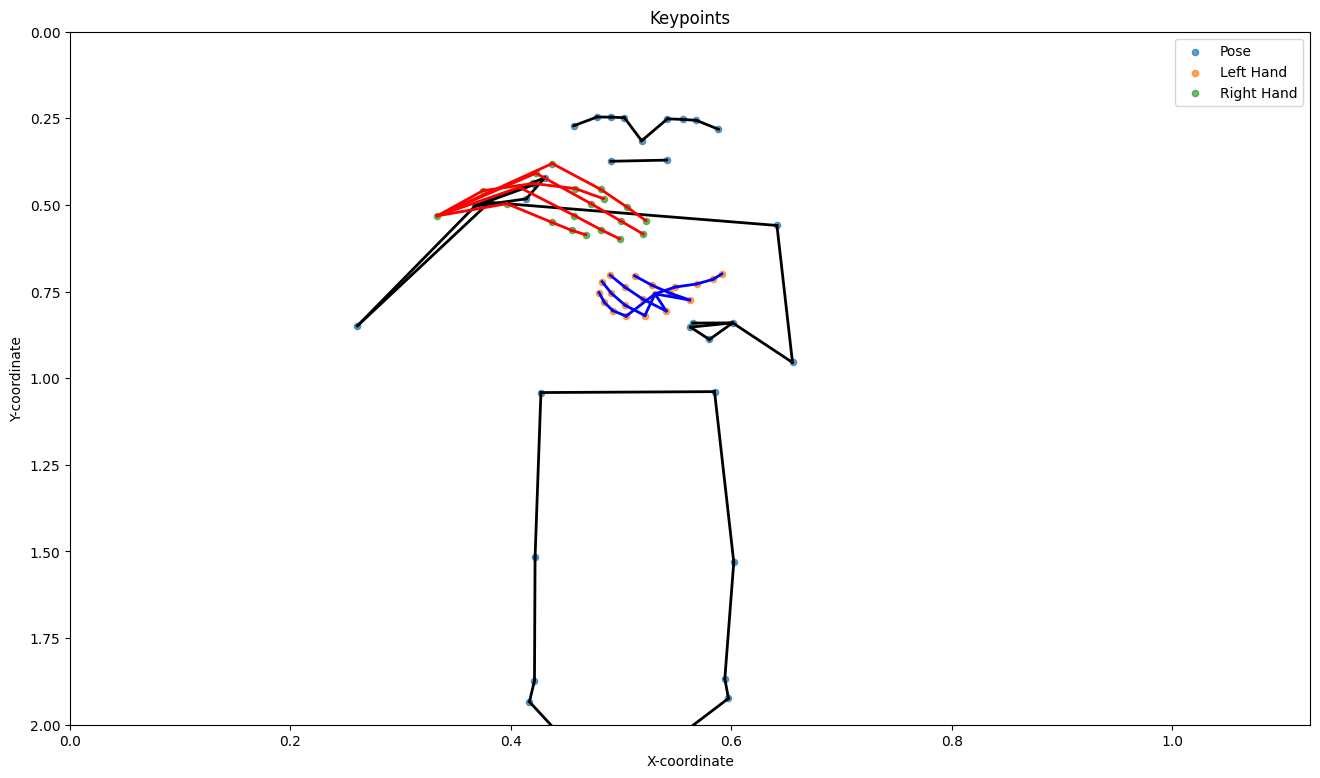

In [85]:
keypoints = np.load('test_interpolation/ulang/02/interpolated/2.npy')
image = plot_keypoints(keypoints, title='Keypoints')

| Original  | Interpolated |
| ------------- | ------------- |
| ![display image](test_interpolation/ulang/02/landmarks.gif) | ![display image](test_interpolation/ulang/02/interpolated.gif) |